# Polygons

## The Problem

Consider an n-sided polygon where n is even. We draw all the lines that connect the vertices, and mark out the intersection points. This creates a graph with the vertices and intersection points as the nodes of the graph, and the edges are the line segments between the vertices and the intersection points. You can refer to the plot below.

We define a start point and an end point as the opposite vertices of the polygon. We also define a "decreasing path" as a path along the edges of the graph that links the start point to the end point, where the distance to the end point is strictly decreasing while moving along the path. Find the total number of decreasing paths available.

## The Solution

In [1]:
import numpy as np
import pandas as pd
import itertools
import operator

from math import sin, cos, pi, sqrt
from typing import List, Tuple, Set, Dict
from functools import cached_property, lru_cache
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

### Create the regular polygon
Let's define some restrictions on the polygon.
1. Centred on (0,0) with radius 1 unit; thus start point is (1,0) and end point is (-1,0)
2. Use the internal angle of a polygon to find the points of the vertices

Some of the code for Line and Point classes are adapted from https://stackoverflow.com/a/20679579. Also written with mathematical reference to https://observablehq.com/@toja/line-box-intersection.

In [2]:
# Rounding precision for floating point calculations
PRECISION = 10
TOLERANCE = 1e-5

def zeroise(a: float or None) -> bool:
    if a is None:
        return None
    return a if abs(a) > TOLERANCE else 0

In [3]:
class Point:
    
    ls = dict()
    
    def __init__(self, x: float, y: float):
        self.x = round(zeroise(x), PRECISION)
        self.y = round(zeroise(y), PRECISION)
        
    @classmethod
    def from_intersection(cls, L1:"LineSegment"=None, L2:"LineSegment"=None) -> "Point":
        '''
        Alternate constructor for Point via intersection of two LineSegments.
        '''
        a1, b1, c1 = (L1.p2.x - L1.p1.x), (L2.p1.x - L2.p2.x), (L2.p1.x - L1.p1.x)
        a2, b2, c2 = (L1.p2.y - L1.p1.y), (L2.p1.y - L2.p2.y), (L2.p1.y - L1.p1.y)
        
        D  = a1 * b2 - b1 * a2
        Dx = c1 * b2 - b1 * c2
        Dy = a1 * c2 - c1 * a2
        
        if D != 0:
            s = Dx / D
            t = Dy / D
            
            if not (0 <= s <= 1 and 0 <= t <= 1):
                return None
        else:
            return None
        
        return cls((1-s)*L1.p1.x + s*L1.p2.x, (1-s)*L1.p1.y + s*L1.p2.y)

    def lies_on(self, L:"LineSegment") -> bool:
        '''
        Checks that the point lies on a given line segment.
        '''
        try:
            if self.x is not None or self.y is not None:
                lower_y, higher_y = sorted([L.p1.y, L.p2.y])
                is_within = (L.p1.x <= self.x <= L.p2.x and lower_y <= self.y <= higher_y)
                is_p1 = (zeroise(L.p1.x - self.x) ==
                         0 and zeroise(L.p1.y - self.y) == 0)
                is_p2 = (zeroise(L.p2.x - self.x) ==
                         0 and zeroise(L.p2.y - self.y) == 0)
                if (is_within or is_p1 or is_p2):
                    return zeroise(self.y - L.p1.y - (L.p2.y - L.p1.y) / zeroise(L.p2.x - L.p1.x) * (self.x - L.p1.x)) == 0
        except ZeroDivisionError:
            return self.x == L.p1.x
        return False
    
    def __eq__(self, other) -> bool:
        if isinstance(other, Point):
            return not zeroise(self.x - other.x) and not zeroise(self.y - other.y)
        return False
    
    def __repr__(self) -> str:
        return f"Point({self.x:{'.3f' if self.x < 0 else ' .3f'}}, {self.y:{'.3f' if self.y < 0 else ' .3f'}})"
    
    def connecting_edges(self, polygon_solver) -> Set:
        '''
        Method by which the point becomes aware of its adjacent edges.
        Can be created at intersection time in the future.
        '''
        return polygon_solver.point_ls[self]
    
    @lru_cache(maxsize=None)
    def dependent_edges(self, polygon_solver) -> Set:
        '''
        Provides the edges that we depend on to calculate self.value.
        In approach one, these are the edges that point towards self.
        '''
        return set(edge for edge in self.connecting_edges(polygon_solver) if edge.direction(self))
        
    @lru_cache(maxsize=None)
    def value(self, polygon_solver) -> int:
        if not self.dependent_edges(polygon_solver):
            return 1
        return sum(edge.other_end(self).value(polygon_solver) for edge in self.dependent_edges(polygon_solver))
    
    def __hash__(self):
        return hash((self.x, self.y))


In [4]:
class LineSegment:
    def __init__(self, p1: "Point", p2: "Point"):
        self.p1, self.p2 = sorted([p1, p2], key=operator.attrgetter('x','y'))
        
    @cached_property
    def L2(self) -> float:
        return sqrt((self.p1.x - self.p2.x)**2 + (self.p1.y - self.p2.y)**2)
    
   
    @cached_property
    def mid(self) -> "Point":
        return Point((self.p1.x + self.p2.x)/2, (self.p1.y + self.p2.y)/2)
    
    def direction(self, pt:"Point"=None) -> bool:
        '''
        Provides the direction label for the graph, by comparing the L2 distances (p1-to-end, p2-to-end).
            True if p1-to-p2; False if p2-to-p1.
        
        If the argument <pt> is provided, then returns True if the direction is pointing towards <pt> (which
            should be one of the ends of the line segment).
        
        Caution: This method should only be used when there are no intersection points between self.p1 and self.p2.
            Otherwise, it does not return a useful directional label.
        '''
        direction = LineSegment(self.p1, END).L2 > LineSegment(self.p2, END).L2
        if pt is None:
            return direction
        else:
            return direction if pt == self.p2 else (not direction)

    @cached_property
    def gradient(self) -> Tuple[float, float]:
        '''
        Creates a tuple used in the visualisation of the direction.
        '''
        p1, p2 = self.p1, self.p2
        multiplier = 1 if self.direction() else -1
        x_coeff = 0 if p1.x == p2.x else 1
        
        if p2.y > p1.y:
            y_coeff = 1
        elif p1.y == p2.y:
            y_coeff = 0
        else:
            y_coeff = -1
        
        try:
            return (multiplier*x_coeff*0.01, multiplier*y_coeff*0.01*abs((p2.y - p1.y)/(p2.x - p1.x)))
        except ZeroDivisionError:
            return (0, multiplier*0.01)
    
    def __eq__(self, other) -> bool:
        if isinstance(other, LineSegment):
            return self.p1 == other.p1 and self.p2 == other.p2
        return False
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def other_end(self, p: "Point") -> "Point":
        '''
        Returns the other end of the line if one end is given, None otherwise.
        '''
        if p == self.p1:
            return self.p2
        elif p == self.p2:
            return self.p1
        else:
            return None
    
    def __repr__(self) -> str:
        return f"LineSegment({self.p1}, {self.p2})"    

In [5]:
def find_next_coordinate(xy: Tuple[float, float], t: float) -> Tuple[float, float]:
    '''
    See https://en.wikipedia.org/wiki/Rotation_matrix for the math behind this.
    '''
    x, y = xy
    return (x*cos(t) - y*sin(t), x*sin(t) + y*cos(t))

def create_regular_polygon(n: int) -> List[Tuple]:
    # Defines a polygon as the list of (x,y) coordinates of the vertices
    theta = 2/n * pi
    polygon = []
    start_xy = (1,0)
    
    current_xy = start_xy
    for i in range(n):
        current_xy = find_next_coordinate(current_xy, theta)
        polygon.append(current_xy)
    polygon = [Point(x,y) for x,y in polygon]
    return polygon

In [6]:
END = Point(-1,0)
START = Point(1,0)

### Find the intersection points
We first create the polygon. Next, we draw a line for every pair of polygon vertices. We then find the intersection points of every pair of line segments.

In [7]:
class PolygonSolver:
    def __init__(self, n, plot=False, **kwargs):
        self.n = n
        self.polygon = create_regular_polygon(n)
        self.line2points, self.point2lines = self.generate_mappings
        
        if plot:
            self.plot_polygon_graph(**kwargs)
    
    @cached_property
    def lines(self):
        return [LineSegment(a,b) for a,b in itertools.combinations(self.polygon, 2)]
    
    @cached_property
    def generate_mappings(self):
        '''
        line2points: Dict[LineSegment, Set[Point]] where each line is mapped to every point on it.
        point2lines: Dict[Point, Set[LineSegment]] where each pt is mapped to each line that crosses it.
        '''
        
        line2points = dict()  
        point2lines = dict()  

        for line in self.lines:
            line2points[line] = set([line.p1, line.p2])

            for point in [line.p1, line.p2]:
                if point not in point2lines:
                    point2lines[point] = set([line])
                else:
                    point2lines[point].add(line)

        for a, b in itertools.combinations(self.lines, 2):
            point = Point.from_intersection(a,b)

            if point != None:
                line2points[a].add(point)
                line2points[b].add(point)

                if point in point2lines:
                    point2lines[point].add(a)
                    point2lines[point].add(b)
                else:
                    point2lines[point] = set([a])
                    point2lines[point].add(b)
        
        return line2points, point2lines
    
    @cached_property
    def line_segments(self):
        line_segments = set()
        for ls, p in self.line2points.items():
            if len(p) == 2:
                line_segments.add(ls)
            else:
                sorted_points = sorted(p, key=operator.attrgetter('x','y'))
                for previous, current in zip(sorted_points, sorted_points[1:]):
                    if previous != current:
                        line_segments.add(LineSegment(previous, current))
        return line_segments

    @cached_property
    def point_ls(self):
    # A Dict[Point: Set[LineSegments]] containing all the line segments for every point
    # TODO: Optimize to avoid checking every point against every line segment (edge).
    # TODO: At some point this approach can be deprecated, once point2lines becomes a mapping to line segments rather than original lines.
        point_ls = dict()
        for point in self.point2lines:
            rhs = set()
            for ls in self.line_segments:
                if point.lies_on(ls):
                    rhs.add(ls)
            point_ls[point] = rhs
        return point_ls
    
    def plot_polygon_graph(self, figsize:int=8, lines:bool=True, points:bool=True, values:bool=True):
        x, y = [point.x for point in self.point2lines], [point.y for point in self.point2lines]

        # Configurations
        limit = 1.1
        head_width = 0.03
        offset = -0.07

        fig, ax = plt.subplots(figsize=(figsize,figsize))
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(axis='both', alpha=0.2)

        # Lines
        if lines:
            for line in self.line_segments:
                color = next(ax._get_lines.prop_cycler)['color']
                ax.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y], color=color)
                plt.arrow(x=line.mid.x, y=line.mid.y,
                          dx=line.gradient[0], dy=line.gradient[1],
                          lw=0, color=color, length_includes_head=True, head_width=head_width)

        # Points
        if points:
            ax.scatter(x, y, c="black")

        # Values
        if values:
            for pt in self.point2lines:
                plt.annotate(pt.value(self), (pt.x+offset, pt.y+offset))
    
    @lru_cache(maxsize=None)
    def solve(self):
        return sorted(self.point2lines.keys(), key=operator.attrgetter('x', 'y'))[0].value(self)
    
    @lru_cache(maxsize=None)
    def progressive_solve(self):
        '''
        Intended as an alternative solver that allows us to progressively solve the graph.
        Only marginally slower than PolygonSolver.solve().
        '''
        iterable = sorted(self.point2lines.keys(), key=operator.attrgetter('x', 'y'), reverse=True)
        for item in tqdm(iterable):
            item.value(self)
        return iterable[-1].value(self)

### Get all the line segments
Every line segment in the diagram above fulfills the following conditions:
1. Both ends of the line segment must be either an intersection point or a vertex
2. They must be an equal or shorter line deriving from one of the already drawn lines

A possible approach would be to:
1. For every line segment that we have generated, first find which points/vertices lie on it.
2. Break up the line segment into smaller line segments where possible
    - Sort the points by x, then within that by y.
    - Line segments are built by going across the list and taking a pair of points as line segments

### Assertion check
At some point, we will want to do an assertion check with a function that implements https://math.stackexchange.com/questions/1010591/what-is-the-number-of-intersections-of-diagonals-in-a-convex-equilateral-polygon#:~:text=For%20example%20diagonals%20of%20a,the%20center%20as%20their%20intersection.

In [8]:
# print(len(line_segments), (n + n*(n-2)*(n-3)/2))
# assert len(line_segments) == n + n*(n-2)*(n-3)/2

### Label all the line segments
Due to the "decreasing path" constraint, there can only be one direction of movement for an edge. We can say that every edge in the graph must be directed. Right angles are particularly helpful in determining where the edge directions point towards.

### Solving the graph

There are two possible approaches to solving this problem.
1. For every node, find the number of paths to reach that node from the start point.
2. For every node, find the number of paths from that node to the end point.

We are going to adopt approach 1, and write our solution as a recursive solver. Its value is the sum of the value of the points that it is dependent on.


Wall time: 124 ms


20171

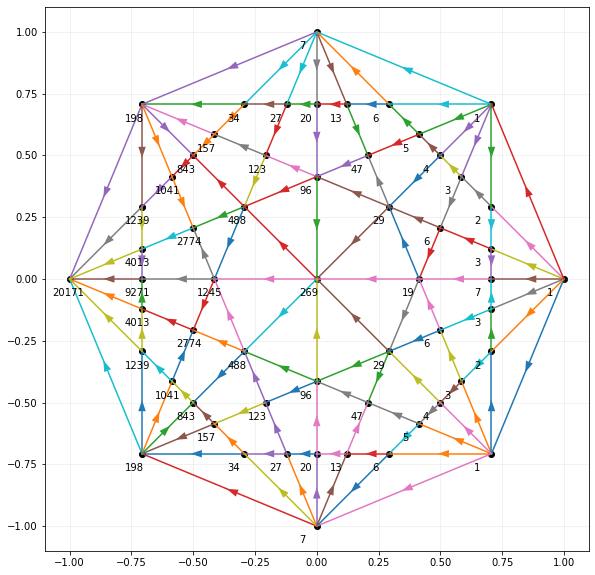

In [9]:
%%time
solver = PolygonSolver(n=8, plot=True, figsize=10, values=True)
solver.progressive_solve()

### Computational time
We are currently running into problems where we take a long time to compute.

There are a few ways to improve this algorithm.
1. Exploit the symmetry in the graph along the x-axis to realise that for any point, $(x_1,y_1).value$ will be the same as $(x_1, -y_1).value$ and thus the calculation only needs to be done once.
2. We probably want to write a list so that we can compute tqdm over it.

In [10]:
solved_values = {
    4: 5,
    6: 121,
    8: 20171,
    10: 81358429,
    12: 684456832669,
    14: 5568879884660439597,
    16: 70555936211501105540280029,
    18: 26104799341295611609637888837125,
    20: 1291955472741982060252246911959200855827998405,
    22: 2094939671828041014920659970754249123969077409681422311431,
    24: 88588819328432079826333654597940902201201554048646005443049400270833,
    26: 25700137005553756583689735404815440662511320905229243688544919482116457097334108224113,
}

a,b = zip(*solved_values.items())

data = {
    'n': a,
    'paths': b
}

df = pd.DataFrame.from_dict(data)
df.set_index('n', drop=True, inplace=True)
df.paths = df.paths.astype('float64')
df['ln_paths'] = np.log(df['paths'])
df['cubert_ln_paths'] = np.cbrt(df['ln_paths'])

df.drop('paths', inplace=True, axis=1)
df.drop('ln_paths', inplace=True, axis=1)
df.plot()

As the plot is close to linear, we think that the growth rate in $n$ (where $n$ is the number of sides of the polygon) is $e^{n^3}$.